<a href="https://colab.research.google.com/github/hadwin-357/ML_Chem/blob/main/RDkit_learn_RW_query.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

RDkit learning [RDkit](https://www.rdkit.org/docs/GettingStartedInPython.html#feature-definitions-used-in-the-morgan-fingerprints)

In [1]:
!pip install rdkit-pypi==2022.3.1.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.7/22.7 MB 9.6 MB/s eta 0:00:00


In [2]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
import time
IPythonConsole.ipython_useSVG =True

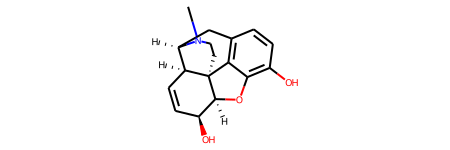

In [5]:
# Read data from different formats
# SMILES
mol = Chem.MolFromSmiles('[H][C@@]12OC3=C(O)C=CC4=C3[C@@]11CCN(C)[C@]([H])(C4)[C@]1([H])C=C[C@@H]2O')
mol

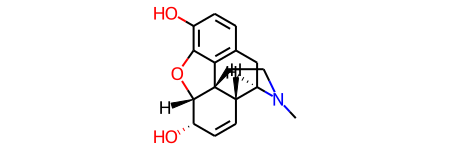

In [6]:
# read from mol block
import requests
morphine_url = 'https://go.drugbank.com/structures/small_molecule_drugs/DB00295.mol'
mol = requests.get(morphine_url).text
mol =Chem.MolFromMolBlock(mol)
mol

In [8]:
# read from PDB
!wget -P /content/data https://files.rcsb.org/download/1K4C.pdb

kcsa = Chem.MolFromPDBFile('./data/1K4C.pdb')


--2024-02-14 20:31:59--  https://files.rcsb.org/download/1K4C.pdb
Resolving files.rcsb.org (files.rcsb.org)... 132.249.213.193
Connecting to files.rcsb.org (files.rcsb.org)|132.249.213.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘/content/data/1K4C.pdb.1’

1K4C.pdb.1              [ <=>                ] 420.50K  --.-KB/s    in 0.06s   

2024-02-14 20:31:59 (6.75 MB/s) - ‘/content/data/1K4C.pdb.1’ saved [430596]



In [27]:
kcsa.GetNumAtoms()
#get residues info for each atoms
residues= [atom.GetPDBResidueInfo() for atom in kcsa.GetAtoms()]
#read out of reisdue info
resinf = [(res.GetResidueNumber(),res.GetResidueName()) for res in residues]
resinf[10:20]

[(2, 'VAL'),
 (2, 'VAL'),
 (2, 'VAL'),
 (2, 'VAL'),
 (2, 'VAL'),
 (2, 'VAL'),
 (3, 'GLN'),
 (3, 'GLN'),
 (3, 'GLN'),
 (3, 'GLN')]

In [30]:
# molecule properties
#properties screening
from rdkit.Chem import Descriptors

MW = Descriptors.MolWt(mol)
HBA = Descriptors.NOCount(mol)
HBD = Descriptors.NHOHCount(mol)
LogP = Descriptors.MolLogP(mol)
conditions = [MW <= 500, HBA <= 10, HBD <= 5, LogP <= 5]
pass_ro5 = conditions.count(True) >= 3
pass_ro5

True

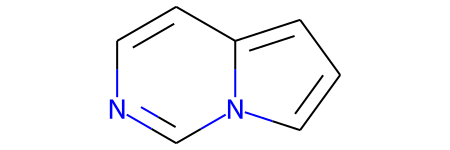

In [34]:
# write molecule with 2D coordiates
from rdkit.Chem import AllChem
m = Chem.MolFromSmiles('c1nccc2n1ccc2')
AllChem.Compute2DCoords(m)
m

In [35]:
#Use SMARTS for substructure matching
from rdkit import rdBase
from rdkit.Chem import AllChem
# some heterocycles
naphthalene = Chem.MolFromSmiles('c12ccccc1cccc2')
benzoxazole = Chem.MolFromSmiles('n1c2ccccc2oc1')
indane = Chem.MolFromSmiles('c1ccc2c(c1)CCC2')
skatole = Chem.MolFromSmiles('CC1=CNC2=CC=CC=C12')
benzene = Chem.MolFromSmiles('c1ccccc1')
quinoline = Chem.MolFromSmiles('n1cccc2ccccc12')

my_molecules = [naphthalene,
                benzoxazole,
                indane,
                skatole,
                benzene,
                quinoline,
               ]

# wriet them into a structured file
with Chem.SDWriter('./data/example.sdf')as w:
  for m in my_molecules:
    w.write(m)

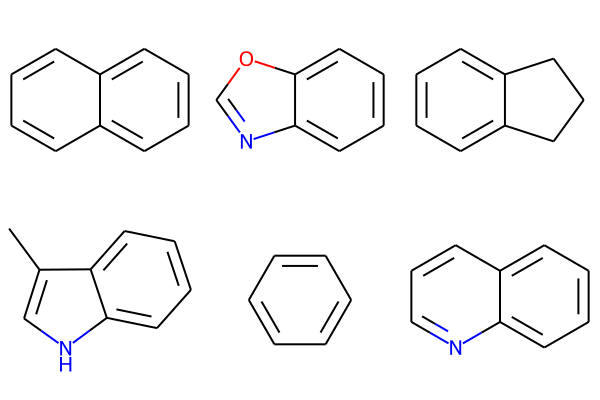

In [36]:
#molecuels visualization
Draw.MolsToGridImage(my_molecules, useSVG=False)

In [40]:
#create inquiry using SMARTS
#SMARTS: https://www.daylight.com/dayhtml/doc/theory/theory.smarts.html
containing_two_rings = Chem.MolFromSmarts('[R2]')
[mol.HasSubstructMatch(containing_two_rings) for mol in my_molecules]

[True, True, True, True, False, True]

In [41]:
#Unlike SMILES, When molecule built from SMARTS, Ringinfo is not automatically calculated
#Chem.GetSSSR() needs to be invoked
#query one: five membered ring fuse to a benzene ring
benzo_five = Chem.MolFromSmarts('[*r5R1]1[cR2]2[cR1][cR1][cR1][cR1][cR2]2[*r5R1][*r5R1]1')
#query two : 6 membered ring fuse to a benzene ring
benzo_six = Chem.MolFromSmarts('[*r6R1]1[cR2]2[cR1][cR1][cR1][cR1][cR2]2[*r6R1][*r6R1][*r6R1]1')

smarts_queries = [benzo_five, benzo_six]
[Chem.GetSSSR(mol) for mol in smarts_queries]

[2, 2]

In [42]:
[AllChem.Compute2DCoords(mol) for mol in smarts_queries]

[0, 0]

In [43]:
for mol in my_molecules:
  AllChem.GenerateDepictionMatching2DStructure(mol, benzo_five, acceptFailure =True)

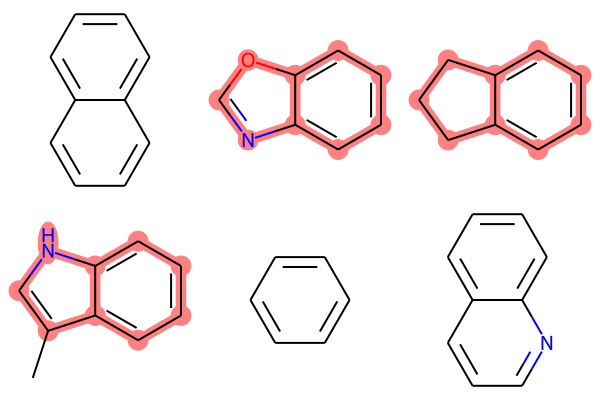

In [44]:
#display the match molecule
highlight_lists=[mol.GetSubstructMatch(benzo_five) for mol in my_molecules]
#draw based on queries
Draw.MolsToGridImage(my_molecules, highlightAtomLists=highlight_lists, useSVG=False)

In [46]:
highlight_lists=[mol.GetSubstructMatch(benzo_six) for mol in my_molecules]

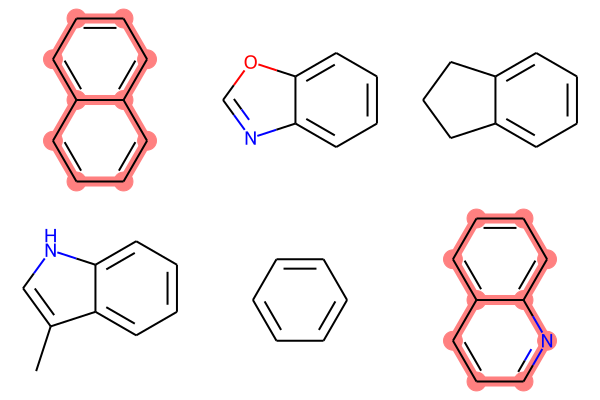

In [47]:
# make sure the molecules are storing information about the SSS match:
highlight_lists = [mol.GetSubstructMatch(benzo_six) for mol in my_molecules]
Draw.MolsToGridImage(my_molecules,
                     highlightAtomLists = highlight_lists,
                     useSVG=False
                    )